# Web Scraping for Indeed.com & Predicting Salaries

In this project, we will practice two major skills: collecting data by scraping a website and then building a binary predictor with Logistic Regression.

We are going to collect salary information on data science jobs in a variety of markets. Then using the location, title and summary of the job we will attempt to predict the salary of the job. For job posting sites, this would be extraordinarily useful. While most listings DO NOT come with salary information (as you will see in this exercise), being to able extrapolate or predict the expected salaries from other listings can help guide negotiations.

Normally, we could use regression for this task; however, we will convert this problem into classification and use Logistic Regression.

- Question: Why would we want this to be a classification problem?
- Answer: While more precision may be better, there is a fair amount of natural variance in job salaries - predicting a range be may be useful.

Therefore, the first part of the assignment will be focused on scraping Indeed.com. In the second, we'll focus on using listings with salary information to build a model and predict additional salaries.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10")

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

The URL here has many query parameters

- `q` for the job search
- This is followed by "+20,000" to return results with salaries (or expected salaries >$20,000)
- `l` for a location 
- `start` for what result number to start on

Let's look at one result more closely. A single `result` looks like

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some more verbose elements removed, we can see that there is some structure to the above:
- The salary is available in a `nobr` element inside of a `td` element with `class='snip`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element="jobTitle`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 

In [1]:
import os
os.chdir('../')

In [2]:
import pandas as pd
import pickle
import requests
import re
import numpy as np
import json

from nltk.corpus import stopwords 
from nltk.stem.snowball import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import metrics

from lib.indeed_parsing import extract_posts, extract_posts_wo_salary
from lib.preprocessing import clean_salary, clean_text, standardize, extract_keywords_into_dummies, is_keyword_in_title_or_summary, map_city, f

import matplotlib.pyplot as plt

%matplotlib inline

### Cities to collect job posts from:

In [3]:
cities = ['New+York', 'Chicago', 'San+Francisco', 'Austin', 'Seattle', 'Los+Angeles', 
          'Philadelphia', 'Atlanta', 'Dallas', 'Pittsburgh', 'Portland', 'Phoenix', 
          'Denver', 'Houston', 'Miami', 'Washington']

### Parse and Collect - Location, Comapny, Salary, Title, Description

In [4]:
df = extract_posts(max_results_per_city=100, cities=cities)

In [5]:
df = pd.read_pickle('data/df.pkl')

### Convert salary string and to a number, averaging a salary range if necessary

In [6]:
df['salary'] = df['salary'].apply(clean_salary)

In [7]:
df.dropna(inplace=True)

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
df.reset_index(drop=True, inplace=True)

### Cleans texts from punctuations and numbers

In [10]:
df['company'] = df['company'].apply(clean_text)
df['summary'] = df['summary'].apply(clean_text)
df['title'] = df['title'].apply(clean_text)
df['city'] = df['city'].astype(str)
df['state'] = df['state'].astype(str)

### Standardize words like: sr -> senior

In [11]:
df['title'] = df['title'].apply(standardize)
df['summary'] = df['summary'].apply(standardize)

## Predicting salaries using Logistic Regression

#### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median)

We could also perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. We don't have to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of salaries

find salary percentile:
- below twentieth 20th
- between 20th and 85th 
- above 85th

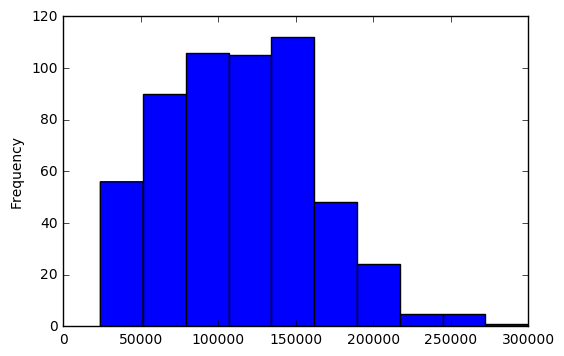

In [12]:
df.salary.plot.hist(bins=10)

In [13]:
twentieth = df['salary'].quantile(0.20)
eightyfifth = df['salary'].quantile(0.85)

In [14]:
def percentile_cls(row):
    salary = row['salary']
    
    if salary < twentieth:
        return 0
    elif salary >= twentieth and salary < eightyfifth:
        return 1  
    else:
        return 2

In [15]:
df['percentile_range'] = df.apply(percentile_cls, axis=1)

In [16]:
df.groupby(['percentile_range'])['salary'].describe()

percentile_range       
0                 count       111.000000
                  mean      51260.058559
                  std       10512.783993
                  min       24000.000000
                  25%       45925.000000
                  50%       50000.000000
                  75%       59992.250000
                  max       69673.000000
1                 count       358.000000
                  mean     115979.497207
                  std       26958.213723
                  min       70000.000000
                  25%       90981.000000
                  50%      120000.000000
                  75%      140000.000000
                  max      160000.000000
2                 count        83.000000
                  mean     190481.927711
                  std       24983.097430
                  min      162500.000000
                  25%      175000.000000
                  50%      180000.000000
                  75%      200000.000000
                  max      300000

In [17]:
stops = set(stopwords.words('english'))

In [18]:
stops.update(['experience','looking','using','work','working','join','company','strong','challenge',
              '130k','net','1','10','17096','2','200k','250k','3','500','7444','74851','7644','7660'])

In [19]:
titles = pd.DataFrame(df.groupby(['percentile_range'])['title'].apply(lambda x: ' '.join(x)))

In [20]:
lsa = Pipeline([('vectorizer', TfidfVectorizer(stop_words=stops, ngram_range=(1,3))),
                ('normalize', Normalizer(copy=False)),
                ('svd', TruncatedSVD(n_components=100, n_iter=10, random_state=42))])

In [21]:
vec = lsa.fit_transform(titles['title'])

In [22]:
explained_variance = lsa.steps[2][1].explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))

Explained variance of the SVD step: 99%


In [23]:
print("Top terms per cluster:")

original_space_centroids = lsa.steps[2][1].inverse_transform(vec)
order_centroids = original_space_centroids.argsort()[:, ::-1]

terms = lsa.steps[0][1].get_feature_names()
for i in range(3):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print

Top terms per cluster:
Cluster 0:
 research
 analyst
 research analyst
 scientist
 specialist
 associate
 phd
 technician
 data
 research associate

Cluster 1:
 data
 scientist
 data scientist
 senior
 engineer
 analyst
 learning
 machine learning
 machine
 senior data

Cluster 2:
 data
 scientist
 data scientist
 senior
 senior data
 senior data scientist
 engineer
 quantitative
 analyst
 learning



In [24]:
summary = df.groupby(['percentile_range'])['summary'].apply(lambda x: ' '.join(x))

In [25]:
lsa = Pipeline([('vectorizer', TfidfVectorizer(stop_words=stops, ngram_range=(1,3))),
                ('normalize', Normalizer(copy=False)),
                ('svd', TruncatedSVD(n_components=100, n_iter=10, random_state=42))])

In [26]:
vecs = lsa.fit_transform(summary.values)

In [27]:
explained_variance = lsa.steps[2][1].explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))

Explained variance of the SVD step: 100%


In [28]:
print("Top terms per cluster:")

original_space_centroids = lsa.steps[2][1].inverse_transform(vecs)
order_centroids = original_space_centroids.argsort()[:, ::-1]

terms = lsa.steps[0][1].get_feature_names()
for i in range(3):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print

Top terms per cluster:
Cluster 0:
 data
 research
 scientist
 analysis
 scientists
 quality
 interpret
 analyze
 analyst
 environmental

Cluster 1:
 data
 learning
 machine
 machine learning
 scientist
 data scientist
 python
 analysis
 analytics
 modeling

Cluster 2:
 data
 learning
 machine
 machine learning
 scientist
 data scientist
 team
 python
 data science
 science



#### Thought experiment: What is the baseline accuracy for this model?

three posibilities: baseline accuracy is 33%

#### Create a Logistic Regression model to predict High/Low salary using statsmodel. Start by ONLY using the location as a feature. Display the coefficients and write a short summary of what they mean.

In [30]:
df['city'] = df.apply(map_city, axis=1)
df['city_suburb'] = df['city'].apply(lambda x: 1 if 'Suburb' in x else 0)
df = df.join(pd.get_dummies(df['city'].apply(f)))

In [31]:
X = pd.get_dummies(df['city'])
y = df['percentile_range']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

lr = LogisticRegression()

model = lr.fit(X_train, y_train)
train_score = lr.score(X_train, y_train)
test_score = lr.score(X_test, y_test)

predict = lr.predict_proba(X_test)
print('train_score:', train_score, 'test_score:', test_score)

('train_score:', 0.72222222222222221, 'test_score:', 0.67391304347826086)


In [33]:
X = df.drop(['city','company','salary','state','summary','title','percentile_range'], axis=1)
y = df['percentile_range']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

lr = LogisticRegression()

model = lr.fit(X_train, y_train)
train_score = lr.score(X_train, y_train)
test_score = lr.score(X_test, y_test)

predict = lr.predict_proba(X_test)
print('train_score:', train_score, 'test_score:', test_score)

('train_score:', 0.71739130434782605, 'test_score:', 0.66666666666666663)


#### Create a few new variables in your dataframe to represent interesting features of a job title.
- For example, create a feature that represents whether 'Senior' is in the title 
- or whether 'Manager' is in the title. 
- Then build a new Logistic Regression model with these features. Do they add any value? 


In [35]:
df = extract_keywords_into_dummies(df, 'title','senior','associate','specialist','technician','lead')

#### Rebuild this model with scikit-learn.
- You can either create the dummy features manually or use the `dmatrix` function from `patsy`
- Remember to scale the feature variables as well!


In [36]:
X = df[['senior','associate','specialist','technician','lead']]
y = df['percentile_range']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

lr = LogisticRegression()

model = lr.fit(X_train, y_train)
train_score = lr.score(X_train, y_train)
test_score = lr.score(X_test, y_test)

predict = lr.predict_proba(X_test)
print('train_score:', train_score, 'test_score:', test_score)

('train_score:', 0.67874396135265702, 'test_score:', 0.6811594202898551)


In [38]:
X = df.drop(['city','company','salary','state','summary','title','percentile_range'], axis=1)
y = df['percentile_range']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

lr = LogisticRegression()

model = lr.fit(X_train, y_train)
train_score = lr.score(X_train, y_train)
test_score = lr.score(X_test, y_test)

predict = lr.predict_proba(X_test)
print('train_score:', train_score, 'test_score:', test_score)

('train_score:', 0.72222222222222221, 'test_score:', 0.68840579710144922)


#### Continue to incorporate other text features from the title or summary that you believe will predict the salary and examine their coefficients

In [40]:
df = extract_keywords_into_dummies(df, 'title','research','analyst','research analyst',
                                   'data analyst','senior research','engineer','project',
                                   'data scientist','machine learning','software',
                                   'data engineer','quantitative','senior data scientist',
                                   'director data','data science','statistical')

In [41]:
X = df.drop(['city','company','salary','state','summary','title','percentile_range'], axis=1)
y = df['percentile_range']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

lr = LogisticRegression()

model = lr.fit(X_train, y_train)
train_score = lr.score(X_train, y_train)
test_score = lr.score(X_test, y_test)

predict = lr.predict_proba(X_test)
print('train_score:', train_score, 'test_score:', test_score)

('train_score:', 0.7657004830917874, 'test_score:', 0.75362318840579712)


In [43]:
df = extract_keywords_into_dummies(df, 'summary','management','data management',
                                   'interpret','quality','python','modeling','intelligence')

In [44]:
X = df.drop(['city','company','salary','state','summary','title','percentile_range'], axis=1)
y = df['percentile_range']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

lr = LogisticRegression()

model = lr.fit(X_train, y_train)
train_score = lr.score(X_train, y_train)
test_score = lr.score(X_test, y_test)

predict = lr.predict_proba(X_test)
print('train_score:', train_score, 'test_score:', test_score)

('train_score:', 0.75362318840579712, 'test_score:', 0.75362318840579712)


In [46]:
df['less_6yrs'] = df['summary'].apply(lambda x: 1 if 'two years' in x or '2 years' in x 
                                      or '3 years' in x or '5 years' in x or '6 years' in x 
                                      or 'five years' in x else 0)

In [47]:
X = df.drop(['city','company','salary','state','summary','title','percentile_range'], axis=1)
y = df['percentile_range']

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

lr = LogisticRegression()

model = lr.fit(X_train, y_train)
train_score = lr.score(X_train, y_train)
test_score = lr.score(X_test, y_test)

predict = lr.predict_proba(X_test)
print('train_score:', train_score, 'test_score:', test_score)

('train_score:', 0.75362318840579712, 'test_score:', 0.75362318840579712)


In [49]:
df = extract_keywords_into_dummies(df, 'summary','phd')

In [50]:
X = df.drop(['city','company','salary','state','summary','title','percentile_range'], axis=1)
y = df['percentile_range']

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

lr = LogisticRegression()

model = lr.fit(X_train, y_train)
train_score = lr.score(X_train, y_train)
test_score = lr.score(X_test, y_test)

predict = lr.predict_proba(X_test)
print('train_score:', train_score, 'test_score:', test_score)

('train_score:', 0.7560386473429952, 'test_score:', 0.75362318840579712)


In [52]:
labels = X.columns.tolist()

In [53]:
results = pd.DataFrame(zip(labels, model.coef_[0]), columns=['feature','coefficient'])

In [54]:
results.reindex(results['coefficient'].abs().sort_values(ascending=False).index)[:15]

,feature,coefficient
22,research,1.501062
30,machine learning,-1.333160
11,Phoenix,1.300009
29,data scientist,-1.290937
16,Washington,-1.273834
42,python,-1.266025
6,Houston,1.212878
9,New York,-1.166083
20,technician,1.059504
43,modeling,-1.007504


#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy, AUC, precision and recall of the model. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.

In [55]:
from sklearn.metrics import classification_report

In [56]:
y_true = y_test
y_pred = lr.predict(X_test)

print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          0       0.74      0.50      0.60        28
          1       0.76      0.92      0.83        91
          2       0.75      0.32      0.44        19

avg / total       0.75      0.75      0.73       138



#### Compare L1 and L2 regularization for this logistic regression model. What effect does this have on the coefficients learned?

In [57]:
from sklearn.linear_model import LogisticRegressionCV

In [58]:
searchCV = LogisticRegressionCV(
    Cs=np.linspace(0.0001, 10, 100),
    penalty='l1',
    cv=10,
    random_state=777,
    solver='liblinear'
)
model = searchCV.fit(X, y)

In [59]:
model.scores_[0].mean(), model.scores_[1].mean()

(0.83749373053846754, 0.66996061428824583)

In [60]:
results = pd.DataFrame(zip(labels, model.coef_[0]), columns=['feature','coefficient'])
results.reindex(results['coefficient'].abs().sort_values(ascending=False).index)[:15]

,feature,coefficient
30,machine learning,-3.819671
33,quantitative,-3.744618
20,technician,2.874048
21,lead,-2.792345
43,modeling,-2.761259
36,data science,-2.183251
42,python,-1.883818
8,Miami,1.817025
12,Pittsburgh,1.809146
17,senior,-1.769039


#### Take ~100 scraped entries with salaries. Convert them to use with your model and predict the salary - which entries have the highest predicted salaries?

In [62]:
test = extract_posts_wo_salary(max_results_per_city=100, cities=cities)

In [63]:
test = pd.read_pickle('data/test.pkl')

In [64]:
test['summary'] = test['summary'].apply(clean_text)
test['title'] = test['title'].apply(clean_text)
test['city'] = test['city'].astype(str)

In [65]:
test['title'] = test['title'].apply(standardize)
test['summary'] = test['summary'].apply(standardize)

In [66]:
test['city'] = test.apply(map_city, axis=1)
test['city_suburb'] = test['city'].apply(lambda x: 1 if 'Suburb' in x else 0)
test = test.join(pd.get_dummies(test['city'].apply(f)))

In [67]:
test = extract_keywords_into_dummies(test, 'title','senior','associate','specialist','technician','lead')
test = extract_keywords_into_dummies(test, 'title','research','analyst','research analyst','data analyst',
                                     'senior research','engineer','project','data scientist','machine learning',
                                     'software','data engineer','quantitative','senior data scientist',
                                     'director data','data science','statistical')

test = extract_keywords_into_dummies(test, 'summary','management','data management','interpret','quality',
                                     'python','modeling','intelligence')

test['less_6yrs'] = test['summary'].apply(lambda x: 1 if 'two years' in x or '2 years' in x 
                                          or '3 years' in x or '5 years' in x or '6 years' in x 
                                          or 'five years' in x else 0)

test = extract_keywords_into_dummies(test, 'summary','phd')

In [68]:
X = test.drop(['city','company','summary','title'], axis=1)

In [69]:
test['percentile_range'] = model.predict(X)

In [70]:
test[test['city'] == 'Los Angeles']

,city,company,summary,title,city_suburb,Atlanta,Austin,Chicago,Dallas,Denver,...,management,data management,interpret,quality,python,modeling,intelligence,less_6yrs,phd,percentile_range
754,Los Angeles,"ProSearch Strategies, Inc.",a data scientist in the linguistics analytics ...,data analyst scientist,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1
755,Los Angeles,Cedars-Sinai,reporting to the research scientist and direct...,data analyst calnoc research,0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0
756,Los Angeles,Riot Games,collaborate with analysts and data scientists ...,technical data analyst,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1
757,Los Angeles,"Neustar, Inc.",data strategy analyst communicating with clien...,data strategy analyst,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0.0,1
758,Los Angeles,The Wonderful Company LLC,work with data scientists to create algorithms...,manager data science and analytics,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,2
759,Los Angeles,Netflix,hunger to continue developing as a data scient...,senior data scientist content science algorithms,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1
761,Los Angeles,Netflix,work with finance experts data scientists and ...,senior data analyst content analytics,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1
764,Los Angeles,Lieberman Research Worldwide (LRW),you ll work on building a cloud based integrat...,software engineer data analytics,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1
765,Los Angeles,Lieberman Research Worldwide (LRW),you ll work on building a cloud based integrat...,software engineer data analytics,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1
768,Los Angeles,USC,supervises data entry programming staff perfor...,statistician ii,0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1
